Here we import packages and define functions for pre-processing the data, including converting from netcdf to dataframe, formatting time columns and converting vapor pressure to water vapor concentration in ppm with Ideal Gas Law.

TO DO:
- Calculate the max correlation and corresponding lag for a whole year (365 days).
- Examine within-day variation in the correlation/optimal lag
- Shift WVIA time series and plot isotopes

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from src.data import make_dataset as mkd # imports source package
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

def nc_to_df(datafile, variable_list):

    # open netcdf file
    ds = xr.open_dataset(datafile)

    # select 4 components of radiation
    selected_ds = ds[variable_list]

    # convert to a pandas.dataframe object
    selected_df = selected_ds.to_dataframe()
    
    selected_df = selected_df.reset_index().set_index(['time'])
    
    try:
        del selected_df['site']
    except:
        print('Nothing to delete, dataframe is single indexed')
    
    return selected_df

def filter_column(df, column, threshmax=20000, threshmin=0):
    '''
    Replaces erroneous outliers with NaN.
    Then, fills value with last valid value 
    or next. Created because of huge spikes
    in H20_ppm. Function only works for H20_ppm 
    at this point. Need a better filtering method.
    One that only filters spikes.
    '''
    
    df.loc[(df[column]<threshmin) | (df[column]>threshmax), column] = None
    return df 

def format_time_columns(df):
    '''Adds a string date column and datetime colums.
    Assumes that the index is called time.'''
    
    df = df.reset_index()
    df['strtime'] = [time.strftime('%y-%m-%d-%H-%M-%S-%f') for time in df['time']]
    df['datetime'] =  pd.to_datetime(df['strtime'], format='%y-%m-%d-%H-%M-%S-%f')
    return df

def volconc_to_ppm(volumeconc, P, T, R=8.31441,  molecularmass=18.01528):
    '''Converts a concentration in metric dimensions 
    to dimensionless ppm value using ideal gas law.
    Need to confirm this conversion is correct'''
    
    moleswater = volumeconc/molecularmass
    volumewater = moleswater*R*(T+273.15)/(P*1000)
    return volumewater*10**6

def rescale(offset, factor, inputdf):
    df = inputdf[['H2Oppm_top','WVIA_H2Oppm', 'time']]
    return df.set_index('time').resample(offset).agg({'H2Oppm_top':np.sum,'WVIA_H2Oppm':np.sum})/factor

#globals
WVIA_vars = ['WVIA_HDOoverH2O', 'WVIA_DoverH', 'WVIA_O18overO16', 'WVIA_H2O_O18_16', 'WVIA_delD', 'WVIA_del18O', 'WVIA_H2Oppm', 'e_hmp','press', 'h2o', 'Ts']
datafile_ts2013_march = '../data/raw/test/raw_MpalaTower_2013_072.nc'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
WVIAdf= mkd.nc_to_df(datafile_ts2013_march, WVIA_vars)
WVIAdf['H2Oppm_top']=volconc_to_ppm(np.array(WVIAdf['h2o']),np.array(WVIAdf['press']), np.array(WVIAdf['Ts']))
WVIAdf = format_time_columns(WVIAdf)

/home/rave/anaconda3/envs/isoflux/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


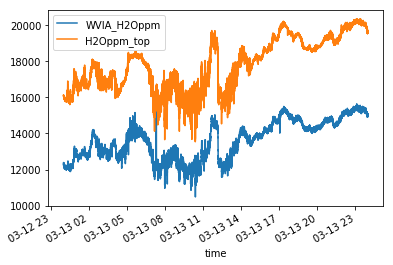

In [12]:
WVIAdf.plot(x = 'time',y=['WVIA_H2Oppm','H2Oppm_top'])
#the time series appear to be different particularly around the 28th minute

In [21]:
WVIAdf = WVIAdf.interpolate(method='linear')
WVIAdf.isna().values.sum()

0

In [22]:
#how much should I initially resample before finding lag?
#http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
#need to divide by factor to normalize ppm aggregation. 1 sec * 10 tenths of sec
WVIAdf_1sec = rescale(inputdf=WVIAdf,offset='1S',factor=10)

Pop off first value because it is artificially low

/home/rave/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


MemoryError: 

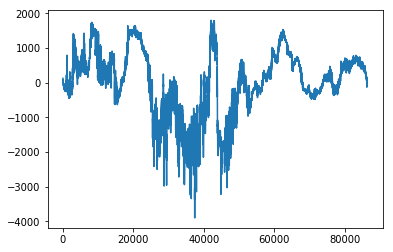

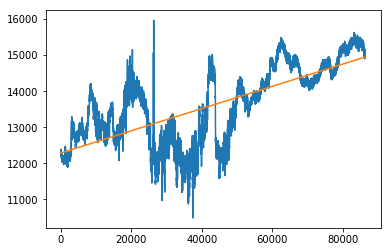

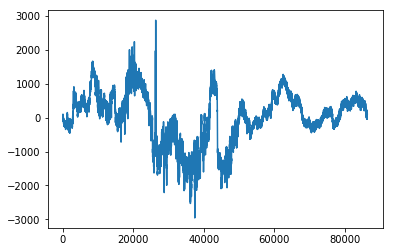

In [23]:
top_ppm = np.array(WVIAdf_1sec['H2Oppm_top'])[1:,]
bottom_ppm = np.array(WVIAdf_1sec['WVIA_H2Oppm'])[1:,]

WVIAdf_1sec.iloc[1:,].plot(y=['WVIA_H2Oppm','H2Oppm_top'])

def fit_model(series):
    
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = np.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    # plot trend
    plt.plot(y)
    plt.plot(trend)
    plt.show()
    # detrend
    detrended = [y[i]-trend[i] for i in range(0, len(series))]
    # plot detrended
    plt.plot(detrended)
    plt.show()
    return detrended
top_ppm_detrended = fit_model(WVIAdf_1sec['H2Oppm_top'])
bottom_ppm_detrended = fit_model(WVIAdf_1sec['WVIA_H2Oppm'])

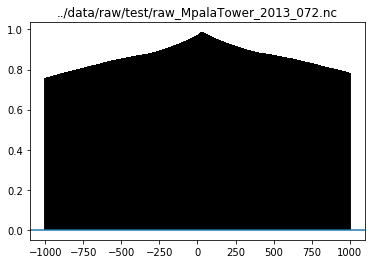

In [25]:
(lags, corrs, line , plot) = plt.xcorr(bottom_ppm_detrended, top_ppm_detrended, maxlags=1000)
plt.title(datafile_ts2013_march)
plt.savefig('foo.png')

In [26]:
maxindex = list(corrs).index(max(corrs))
print("The best lag is", lags[maxindex], "seconds with a correlation of", max(corrs))

The best lag is 28 seconds with a correlation of 0.9861738359843989


## Old code that might still be useful

In [ ]:
# unused
def check_negatives(df):
    for val in df.value:
        if val < 0:
            print('We got a negative!')
    print('Done checking for negatives')
    return

def big_changes_filter():
    brf['difference'] = brf.diff(periods=1).value # the .diff method gets rate of change
    for i, diffval in enumerate(brf.difference):
        if abs(diffval) > 6:
            brf.value[i] = None 
            brf.difference[i] = None
        if abs(brf.value[i]) > 40:
            brf.value[i] = None 
            
def std_filter():
    stddev= np.sqrt(np.sum((brf.difference-brf.difference.mean())**2)/len(brf.difference))
    brf['stddevs']=brf.difference/stddev
    for i, std in enumerate(brf.stddevs):
    if abs(std) > 4:
        brf['value'][i] = None 
        brf['difference'][i] = None
        

In [ ]:
# import plotly as py
# import cufflinks as cf
# # cf.set_config_file(offline=True)
# WVIAdf['H2Oppm_top'].iplot(filename='cufflinks/line-example')

# trying to filter the top ppm by the 1st derivitave to remove big spikes that occur over 1 tenth sec
# signal, not noise!
# WVIAdf['H2Oppm_top_1std']=abs(WVIAdf['H2Oppm_top'].diff())
# WVIAdf = filtercolumn(WVIAdf,'H2Oppm_top_1std', threshmax=200)
# WVIAdf.loc[WVIAdf['H2Oppm_top_1std']==None, 'H2Oppm_top'] = None

Idea, use cross spectrum analysis to look at how the top and bottom ppm vary together over large time scales. Cross spectrum will be useful for more interesting questions as well.

/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


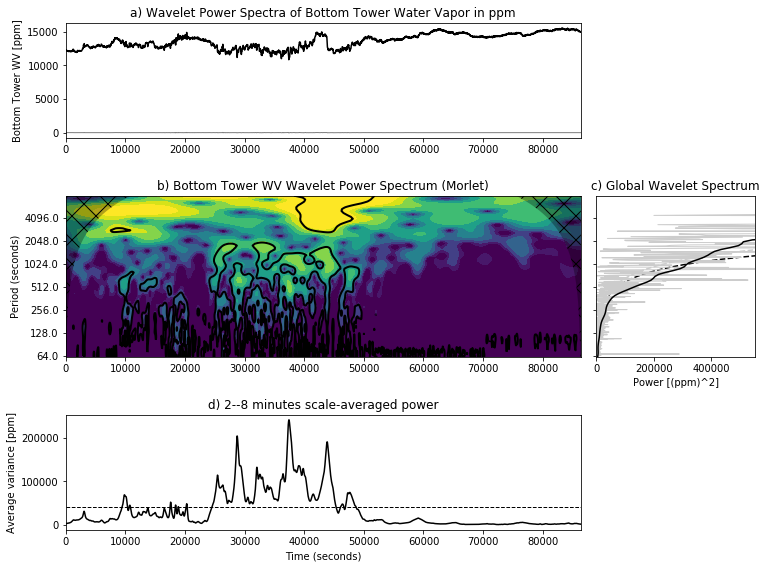

In [16]:
import numpy
from matplotlib import pyplot

import pycwt as wavelet
from pycwt.helpers import find

# Then, we load the dataset and define some data related parameters. In this
# case, the first 19 lines of the data file contain meta-data, that we ignore,
# since we set them manually (*i.e.* title, units).
# url = 'http://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
# dat = numpy.genfromtxt(url, skip_header=19)
# title = 'NINO3 Sea Surface Temperature'
# label = 'NINO3 SST'
# units = 'degC'
# t0 = 1871.0
# dt = 0.25  # In years


dat = numpy.array(WVIAdf5sec['WVIA_H2Oppm']) # sub in my array
title = 'Wavelet Power Spectra of Bottom Tower Water Vapor in ppm'
label = 'Bottom Tower WV'
units = 'ppm'
t0 = 0
dt = 30  # In seconds

# We also create a time array in years.
N = dat.size
t = numpy.arange(0, N) * dt + t0

# We write the following code to detrend and normalize the input data by its
# standard deviation. Sometimes detrending is not necessary and simply
# removing the mean value is good enough. However, if your dataset has a well
# defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# above mentioned website, it is strongly advised to perform detrending.
# Here, we fit a one-degree polynomial function and then subtract it from the
# original data.
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

# The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
# sel = find((period >= 2) & (period < 8))
sel = find((period >= 120) & (period < 1800)) #substitute my own periods of interest
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (seconds)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} minutes scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (seconds)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])
pyplot.show()
fig.savefig('30secondstep_wvia_day.png')


Write Func to resample Dataframe to 10 minute frequency

Resample both top and bottom tower H20ppm measurements and compute correlogram for single day

Run wavelet analysis with Molet wavelet to get spectral analysis figure showing how lag correlations varies with period (10, 20 ,30 minute periods during a day) and with time over the course of a year (multiple days). This will let us see if the lag changes significantly throughout the year, hopefully. 

use df shift method to shift values of WVIA backward to match with corresponding measurements at the top of the tower

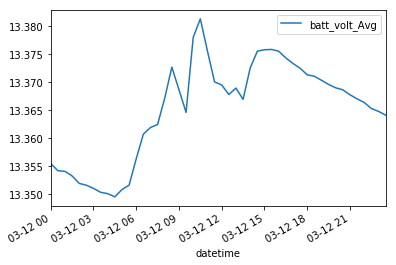

In [4]:
datafile_flux2013 = '../data/raw/flux/raw_MpalaTower_2013_071.nc'
variable_list_flux2013 = ['wnd_spd','press_mean','batt_volt_Avg','batt_volt_Std']

df = convert_to_df(datafile_flux2013, variable_list_flux2013)

df = df.reset_index()
df['strtime'] = [time.strftime('%y-%m-%d-%H-%M-%S-%f') for time in df['time']]
df['datetime'] =  pd.to_datetime(df['strtime'], format='%y-%m-%d-%H-%M-%S-%f')
df.plot(x='datetime', y='batt_volt_Avg')

Resample DF to given interval and plot

In [ ]:
resamp_5min_df = df.resample('5T', on='datetime').mean()
resamp_5min_df.reset_index().plot(x='datetime', y='WVIA_H2Oppm')

## why are there two different versions of the WVIA data and why are the .dat files in ts_data folder produced with a V11 program?
### I checked the difference between the files, output is in my tower_programs folder. It seems that there isn't much difference, the variables all look the same, but yet the file size difference between a ts file and a wvia file is an order of mag
## why is the wvia data renamed ts in each file? Why does the ts data have a shorter time range (2013-2015) than the wvia data (2012-2016)
## Also, there exists a V12 program,  MainTowerCR3000_V12.CR3 yet I can find no outputs that use this program in the raw netcdf folder (haven't checked all the ts_data files)

In [9]:

metaheader = Dataset('../data/raw/test/raw_MpalaTower_2012_167_wvia.nc')
metaheader

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    featureType: timeSeries
    institution: Princeton University
    format: TOA5
    creator_email: kcaylor@princeton.edu
    keywords: eddy covariance, isotope hydrology, land surface flux
    summary: This raw data comes from the MPALA Flux Tower, which is maintained by the Ecohydrology Lab at Mpala Research Centre in Laikipia, Kenya. It is part of a long-term monitoring project that was originally funded by NSF and now runs with support from Princeton. Its focus is on using stable isotopes to better understand water balance in drylands, particularly transpiration and evaporation fluxes.
    id: MPALA Tower
    naming_authority: caylor.princeton.edu
    datafile: WVIA
    license: MIT License
    creator_name: Kelly Caylor
    acknowledgement: Funded by NSF and Princeton University
    local_timezone: Africa/Nairobi
    Conventions: CF-1.6
    source: Flux tower sensor data CR3000_

In [5]:
metaheader = Dataset('../data/raw/test/raw_MpalaTower_2013_071_ts.nc')
metaheader

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    featureType: timeSeries
    datafile: ts_data
    logger: CR3000_SN4709
    creator_name: Kelly Caylor
    license: MIT License
    acknowledgement: Funded by NSF and Princeton University
    creator_email: kcaylor@princeton.edu
    format: TOA5
    local_timezone: Africa/Nairobi
    Conventions: CF-1.6
    source: Flux tower sensor data CR3000_SN4709_ts_data.dat, MainTowerCR3000_V11.cr3, 39879
    program: MainTowerCR3000_V11.cr3
    keywords: eddy covariance, isotope hydrology, land surface flux
    title: Flux Tower Data from MPALA
    station_name: MPALA Tower
    summary: This raw data comes from the MPALA Flux Tower, which is maintained by the Ecohydrology Lab at Mpala Research Centre in Laikipia, Kenya. It is part of a long-term monitoring project that was originally funded by NSF and now runs with support from Princeton. Its focus is on using stable isotopes to better under

Kelly Meeting Notes

Where the Craig-Gordon Model may not hold in drylands

1. When leaves transpire a small amount relative to their volume, pool >> flux and fractionation can occur. This can happen a  lot in drylands as stomatal conductance changes. When stomatal conductance at max, leaf transpires all water content = no fractionation.

2. Water in the soil is treated like a homogenous store ( a bucket) by Craig-Gordon model. Instead, we can think of each pore in the soil as a reservoir in our alternative model. If a pore is totally evaporated, no fractionation occurs out of that pore, but partially evaporated pores will fractionate. Accounting for the heterogenaity of water distribution in soil may provide a better model of measuring the source of isotope fractionation.

Hypothesis: Soil behavior as a single, homogenous reservoir or porous reservoir depends on the water content, Θ

We need to introduce a model using Θ to predict isotopic concentrations in vegetation and soil

Understanding and modeling how isotope fractionation can change with soil moisture state will give us a better understanding of evapotranspiration dynamics and plant water sources in Mpala and drylands in general. This matters because farmers need to know how plants use water as demand for water increases. 



Criteria for good flux data

* coincides with good precip, voltage, wind data
* day to couple day time span
* large wind eddy events as opposed to small ones
* during growing season
* read steve's paper on waves lab website for examples


Analysis Steps

1. Clean data and select time chunks to study
2. implement Craig model of isotope fractionation in python (see notebook) and compare with observations
3. implement new model that uses soil moisture as a first order state variable that potentially affects fractionation in both soils and leaves (see AGU presentation that kelly linked for related analysis)
4. Compare new model to observations and see which model did a better job